In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-data/data.csv


In [2]:
import seaborn as sns
import datetime as dt
from datetime import timedelta
import matplotlib.pyplot as plt

import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# **Load Data**

In [3]:
df = pd.read_csv('/kaggle/input/ecommerce-data/data.csv', encoding='unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# **Data Cleaning**

In [4]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


There are some negative values in the Quantity and UnitPrice column, we'll drop those values as these are not possible

In [6]:
df = df[(df['Quantity']>0) & (df['UnitPrice']>0)]
df.describe()
df.shape

(530104, 8)

In [7]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     132220
Country             0
dtype: int64

We have nearly 25% nulls in the CustomerId column therefore dropping those rows would mean significant data loss. We can explore the option of replacing those values with invoice number instead.

In [8]:
len(df.groupby("CustomerID")["CustomerID"].count())

4338

In [9]:
df['CustomerID'] = df['CustomerID'].fillna(df['InvoiceNo'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 530104 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    530104 non-null  object 
 1   StockCode    530104 non-null  object 
 2   Description  530104 non-null  object 
 3   Quantity     530104 non-null  int64  
 4   InvoiceDate  530104 non-null  object 
 5   UnitPrice    530104 non-null  float64
 6   CustomerID   530104 non-null  object 
 7   Country      530104 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 36.4+ MB


In [10]:
len(df.groupby("CustomerID")["CustomerID"].count())

5766

Creating Column Revenue out of UnitPrice and Quantity

In [11]:
df['Revenue'] = df['Quantity'] * df['UnitPrice']
df.describe()

,Quantity,UnitPrice,Revenue
count,530104.000000,530104.000000,530104.000000
mean,10.542037,3.907625,20.121871
std,155.524124,35.915681,270.356743
min,1.000000,0.001000,0.001000
25%,1.000000,1.250000,3.750000
50%,3.000000,2.080000,9.900000
75%,10.000000,4.130000,17.700000
max,80995.000000,13541.330000,168469.600000


# **RFM**

Converting data type of InvoiceDate column to datetime

In [12]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

Since this is an old dataset, we need to add a reference date to reduce the Recency value. Keeping the original date will have the Recency value too large to be relevant.

In [13]:
reference_date = df['InvoiceDate'].max() + timedelta(days=1)
reference_date

Timestamp('2011-12-10 12:50:00')

In [14]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'count',
    'Revenue': 'sum' 
})

rfm.head()

,InvoiceDate,InvoiceNo,Revenue
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


Renaming columns to Recency, Frequency and MonetaryValue

In [15]:
rfm.rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'Revenue': 'MonetaryValue'}, inplace=True)
rfm = rfm.reset_index()
rfm

,CustomerID,Recency,Frequency,MonetaryValue
0,12346.0,326,1,77183.60
1,12347.0,2,182,4310.00
2,12348.0,75,31,1797.24
3,12349.0,19,73,1757.55
4,12350.0,310,17,334.40
...,...,...,...,...
5761,581439,1,635,6637.59
5762,581492,1,731,7689.23
5763,581497,1,59,3217.20
5764,581498,1,218,5664.89


Plotting data distribution for Recency, Frequency and MonetaryValue

Text(0.5, 1.0, 'Boxplots for Recency, Frequency and MonetaryValue')

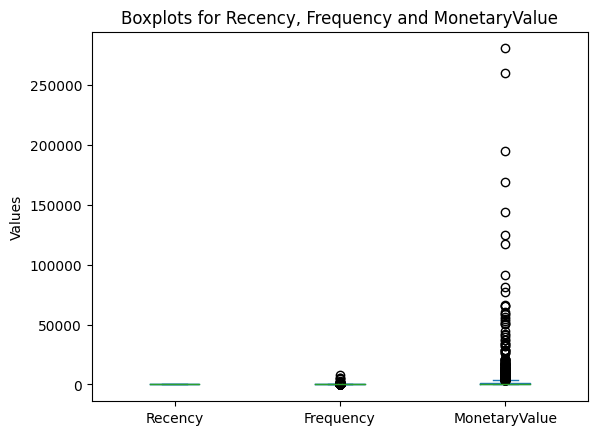

In [16]:
rfm.plot(kind='box')
plt.ylabel('Values')
plt.title('Boxplots for Recency, Frequency and MonetaryValue')

We can see that the data suffers from outliers which can cause inaccurate clusters. Hence, we will normalize the data using standard scaler.

In [17]:
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm[['Recency','Frequency','MonetaryValue']])
rfm_normalized = pd.DataFrame(rfm_normalized, columns=['Recency','Frequency','MonetaryValue'])
rfm_normalized.sort_values(by='MonetaryValue',ascending=False)

,Recency,Frequency,MonetaryValue
1689,-1.037895,9.454839,35.153339
4201,-1.046880,1.615772,32.558259
3728,-0.983982,1.167825,24.336017
3008,-1.046880,-0.423816,21.042614
1879,-1.046880,26.605479,17.929911
...,...,...,...
4754,1.343279,-0.428581,-0.233520
5272,0.265012,-0.433346,-0.233526
4523,1.927341,-0.433346,-0.233544
5608,-0.705429,-0.433346,-0.233556


Text(0.5, 1.0, 'Boxplots for Recency, Frequency and MonetaryValue')

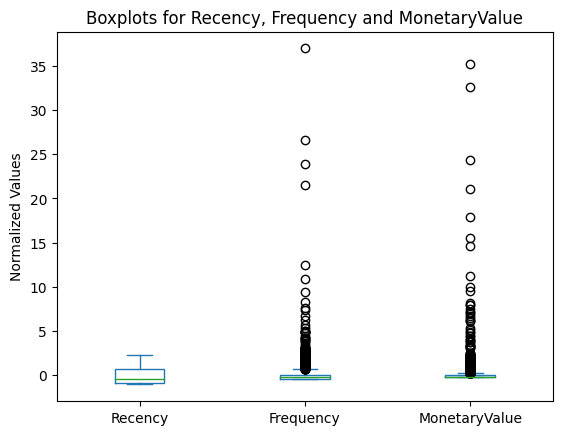

In [18]:
rfm_normalized.plot(kind='box')
plt.ylabel('Normalized Values')
plt.title('Boxplots for Recency, Frequency and MonetaryValue')

# **Optimum Clusters**

We'll use the wss score and the silhouette score methods to determine the optimum number of clusters

In [19]:
K = range(1,12)
wss = []
for k in K:
    kmeans=KMeans(n_clusters=k,init="k-means++", n_init="auto")
    kmeans=kmeans.fit(rfm_normalized)
    wss_iter = kmeans.inertia_
    wss.append(wss_iter)
mycenters = pd.DataFrame({'Clusters' : K, 'WSS' : wss})
mycenters

,Clusters,WSS
0,1,17298.000000
1,2,12270.645780
2,3,7577.562000
3,4,5859.363649
4,5,4311.011491
5,6,3497.832196
6,7,2854.949690
7,8,2620.726455
8,9,2254.912157
9,10,2129.446574


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Clusters', ylabel='WSS'>

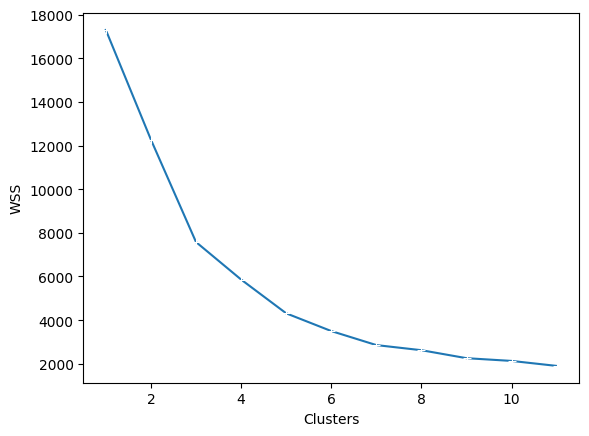

In [20]:
# Plotting the elbow plot
sns.lineplot(x = 'Clusters', y = 'WSS', data = mycenters, marker="+")

Here, we see two elbow points i.e at 3 clusters and 6 clusters. WSS reduction slows significantly after 3 clusters, indicating that 3 might be an ideal number of clusters. There’s another, smaller “elbow” around 6 clusters, where the WSS reduction slows further. We'll now use the silhouette score method to zero in on optimum clusters from 3 & 6.

In [21]:
K = range(2,12)
silhouette = []
for k in K:
    kmeans=KMeans(n_clusters=k,init="k-means++",n_init="auto",random_state=200)
    kmeans=kmeans.fit(rfm_normalized)
    kmeans.fit(rfm_normalized)
    cluster_labels = kmeans.labels_
    score = silhouette_score(rfm_normalized, cluster_labels)
    silhouette.append(score)
mycenters = pd.DataFrame({'Clusters' : K, 'Sil_Score' : silhouette})
mycenters

,Clusters,Sil_Score
0,2,0.932243
1,3,0.545204
2,4,0.548212
3,5,0.556556
4,6,0.423756
5,7,0.486310
6,8,0.464776
7,9,0.464542
8,10,0.453738
9,11,0.422829


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Clusters', ylabel='Sil_Score'>

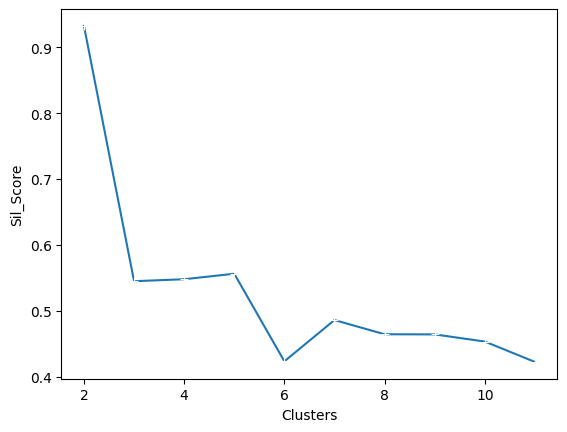

In [22]:
# Plottin the elbow plot
sns.lineplot(x = 'Clusters', y = 'Sil_Score', data = mycenters, marker="+")

From the silhouette scores we see that the best clustering can be done at 2 clusters but 3-5 number of clusters are our second best option. We shall try 2 and 3 clusters for our analysis and see which is the best fit for us.

In [23]:
kmeans_2 = KMeans(n_clusters = 2, max_iter=50, n_init="auto" )
kmeans_2.fit(rfm_normalized)
kmeans_3 = KMeans(n_clusters = 3, max_iter=50, n_init= "auto")
kmeans_3.fit(rfm_normalized)

KMeans(max_iter=50, n_clusters=3, n_init='auto')

In [24]:
rfm_normalized.loc[:,'CustomerID'] = rfm['CustomerID']
rfm_normalized.head()

,Recency,Frequency,MonetaryValue,CustomerID
0,1.873428,-0.433346,9.513821,12346.0
1,-1.037895,0.429189,0.310680,12347.0
2,-0.381949,-0.290385,-0.006654,12348.0
3,-0.885140,-0.090238,-0.011666,12349.0
4,1.729659,-0.357100,-0.191395,12350.0


In [25]:
rfm_normalized_2 = rfm_normalized.copy()
rfm_normalized_3 = rfm_normalized.copy()

In [26]:
rfm_normalized_3['Cluster'] = kmeans_3.labels_
rfm_normalized_3.groupby('Cluster')['Cluster'].count()

Cluster
0    3768
1    1985
2      13
Name: Cluster, dtype: int64

In [27]:
rfm_normalized_2['Cluster'] = kmeans_2.labels_
rfm_normalized_2.groupby('Cluster')['Cluster'].count()

Cluster
0    5753
1      13
Name: Cluster, dtype: int64

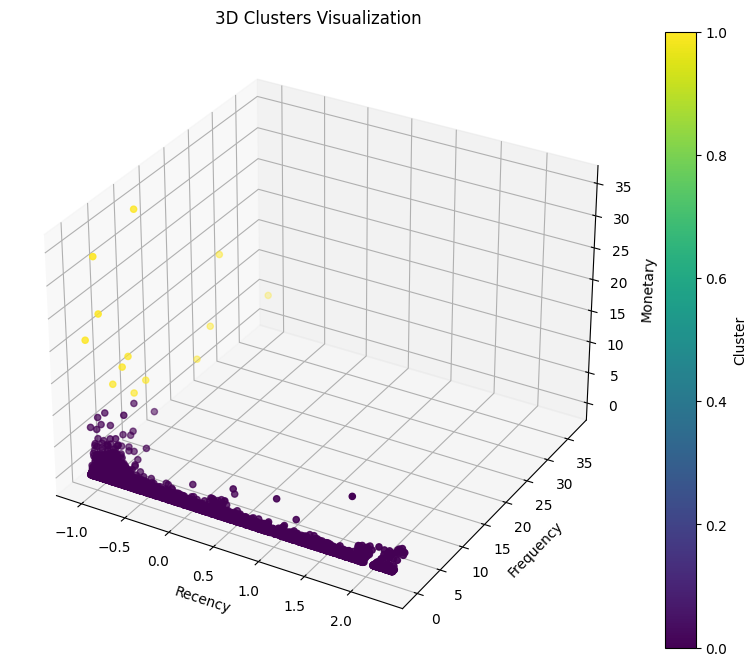

In [28]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(rfm_normalized_2['Recency'], rfm_normalized_2['Frequency'], 
           rfm_normalized_2['MonetaryValue'],
           c=rfm_normalized_2['Cluster'], cmap='viridis')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('3D Clusters Visualization')
plt.colorbar(sc, ax=ax, label='Cluster')
plt.show()

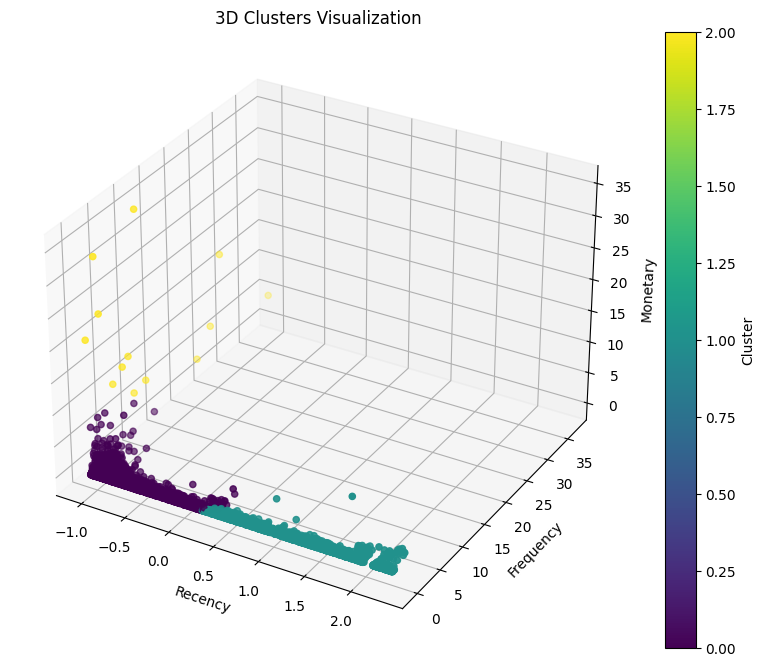

In [29]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(rfm_normalized_3['Recency'], rfm_normalized_3['Frequency'], 
           rfm_normalized_3['MonetaryValue'],
           c=rfm_normalized_3['Cluster'], cmap='viridis')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('3D Clusters Visualization')
plt.colorbar(sc, ax=ax, label='Cluster')
plt.show()

From the above two scatter plots we can see that dividing the data into 3 clusters gives us a more detailed segmentation on customers. This approach would allow for more targeted marketing and customer engagement strategies.

In [30]:
cluster_centers = kmeans_3.cluster_centers_
print("Cluster Centers:\n", cluster_centers)

Cluster Centers:
 [[-0.64347421  0.06790845  0.01926497]
 [ 1.22904861 -0.20623615 -0.13942958]
 [-1.01370301 11.78658113 15.69374136]]


# Cluster Analysis 

# Cluster 0:
* Recency: A negative value for recency indicates that this cluster represents customers who have made purchases recently.
* Frequency: The positive value for frequency suggests that these customers have purchased somewhat frequently.
* Monetary Value: The low positive value here suggests that customers in this cluster spend low amounts per purchase.
* These could be categorized as moderate value customers as they might be fairly new to the platform but have made somewhat frequent purchases.

# Cluster 1:
* Recency: A positive value for recency suggests that customers in this cluster have made their most recent purchases longer ago, meaning they may not be very recent shoppers.
* Frequency: The negative value for frequency indicates that these customers have purchased less frequently.
* Monetary Value: The negative monetary value suggests that these customers tend to spend relatively low amounts on their purchases.
* These could be categorized as low value customers or waining customer segment as it's been quite sometime since their last purchase.

# Cluster 2:
* Recency: A negative value for recency indicates that these customers have purchased quite recently.
* Frequency: A very high positive value for frequency suggests that these customers have made frequent purchases historically, but perhaps their more recent purchases have been spaced out (as indicated by the negative recency).
* Monetary Value: The very high positive value for monetary value indicates that these customers tend to spend a lot per purchase.
* These are the company's high value customers as this segment has performed well in all of the three parameters.

# Targeted Marketing Suggestions

**High Value Customers**
* **Reward & Retain**: Offer loyalty rewards, exclusive discounts, or personalized offers to retain them.
* **Personalized Communication**: Tailor communications to acknowledge their value and ensure they feel valued.
* **Upsell Opportunities**: Since they are engaged and high-spending, consider promoting premium products or services.

**Moderate Value Customers**
* **Incentivize Engagement**: Encourage them to become high-value customers through targeted incentives, like loyalty points or tiered rewards.
* **Educational Campaigns**: Offer information about new products, upgrades, or benefits to stimulate interest.
* **Monitor for Potential**: Track these customers to see if they increase spending or frequency with the right nudges, as they have potential to move into the high-value category.

**Low Value Customers**
* **Win-back Campaigns**: Offer exclusive discounts to lure them back. For example, offer a significant discount on their next purchase to reignite interest.
* **Gather Feedback**: Reach out to these customers to understand why they have not been purchasing frequently. Offer them an incentive (e.g., discount, loyalty points) to fill out a short survey about their experience.